In [1]:
from qepy import *
from yambopy import *
from qepy import PwIn
import matplotlib.pyplot as plt
import numpy as np
from schedulerpy import *
from __future__ import print_function, division
import sys
import argparse

In [2]:
# create the input files
def get_inputfile():
    """ Define a Quantum espresso input file for boron nitride
    """ 
    qe = PwIn()
    qe.atoms = [['N',[0.0,0.0,0.5]],
                ['B',[1.0/3.0,2.0/3.0,0.5]]]
    qe.atypes = {'B': [10.811, "B.pbe-mt_fhi.UPF"],
                 'N': [14.0067,"N.pbe-mt_fhi.UPF"]}

    qe.control['prefix'] = "'%s'"%prefix
    qe.control['verbosity'] = "'high'"
    qe.control['wf_collect'] = '.true.'
    qe.control['pseudo_dir'] = "'../pseudos/'"
    qe.system['celldm(1)'] = 4.7
    qe.system['celldm(3)'] = layer_separation/qe.system['celldm(1)']
    qe.system['ecutwfc'] = 60
    qe.system['occupations'] = "'fixed'"
    qe.system['nat'] = 2
    qe.system['ntyp'] = 2
    qe.system['ibrav'] = 4
    qe.kpoints = [9, 9, 1]
    qe.electrons['conv_thr'] = 1e-10
    return qe

#scf
def scf(folder='scf'):
    if not os.path.isdir(folder):
        os.mkdir(folder)
    qe = get_inputfile()
    qe.control['calculation'] = "'scf'"
    qe.write('%s/%s.scf'%(folder,prefix))
    
#nscf
def nscf(kpoints,folder='nscf'):
    if not os.path.isdir(folder):
        os.mkdir(folder)
    qe = get_inputfile()
    qe.control['calculation'] = "'nscf'"
    qe.electrons['diago_full_acc'] = ".true."
    qe.electrons['conv_thr'] = 1e-8
    qe.system['nbnd'] = 60
    qe.system['force_symmorphic'] = ".true."
    qe.kpoints = kpoints
    qe.write('%s/%s.nscf'%(folder,prefix))

#bands
def bands():
    if not os.path.isdir('bands'):
        os.mkdir('bands')
    qe = get_inputfile()
    qe.control['calculation'] = "'bands'"
    qe.electrons['diago_full_acc'] = ".true."
    qe.electrons['conv_thr'] = 1e-6
    qe.system['nbnd'] = 6
    qe.system['force_symmorphic'] = ".true."
    qe.ktype = 'crystal'
    qe.set_path(p)
    qe.write('bands/%s.bands'%prefix)
    
def run_scf():
    print("running scf:")
    qe_run = scheduler() 
    qe_run.add_command("cd scf; mpirun -np %d %s -inp %s.scf > scf.log"%(nthreads,pw,prefix))
    qe_run.run()
    print("done!")
    
def run_nscf():
    print("running nscf:")
    qe_run = scheduler()
    qe_run.add_command("cp -r scf/%s.save nscf/"%prefix)
    qe_run.add_command("cd nscf; mpirun -np %d %s -inp %s.nscf > nscf.log"%(nthreads,pw,prefix))
    qe_run.run()
    print("done!")

def run_bands():
    print("running bands:")
    qe_run = scheduler() 
    qe_run.add_command("cp -r scf/%s.save bands/"%prefix)
    qe_run.add_command("cd bands; mpirun -np %d %s -inp %s.bands -nk %d > bands.log"%(nthreads,pw,prefix,nthreads))
    qe_run.run()
    qe_run.clean()
    print("done!")
    
def run_plot():
    print("running plotting:")
    xml = PwXML(prefix="%s"%prefix,path='bands')
    xml.plot_eigen(p)

In [7]:
kpoints = [12,12,1]
kpoints_double = [24,24,1]
qpoints = [3,3,1]
layer_separation = 12
pw = 'pw.x'
q2r = 'q2r.x'
matdyn = 'matdyn.x'
yambo = 'yambo'
prefix = 'bn'
nthreads = 4

npoints = 10 
p = Path([ [[0.0, 0.0, 0.0],'G'],
           [[0.5, 0.0, 0.0],'M'],
           [[1./3,1./3,0.0],'K'],
           [[0.0, 0.0, 0.0],'G']], [int(npoints*2),int(npoints),int(sqrt(5)*npoints)])

# scheduler
scheduler = Scheduler.factory

In [14]:
# create input files and folders
scf()
nscf(kpoints)
nscf(kpoints_double, folder='nscf_double')
bands()

In [15]:
#run the scf calculation
run_scf()

running scf:
running job...
done!

done!


In [16]:
#run the nscf calculation
run_nscf()

running nscf:
running job...
done!

done!


running bands:
running job...
done!

done!
running plotting:
reading data-file.xml


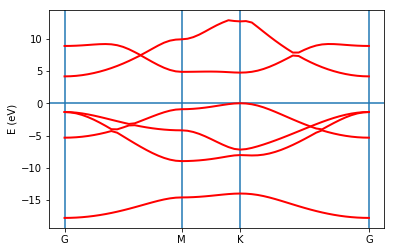

In [4]:
#compute and plot the bands
run_bands()
run_plot()

Now perform the yambo computation

In [16]:
if not os.path.isdir('database'):
    os.mkdir('database')

#check if the nscf cycle is present
if os.path.isdir('nscf/bn.save'):
    print('nscf calculation found!')
else:
    print('nscf calculation not found!')
    exit() 

#check if the SAVE folder is present
if not os.path.isdir('database/SAVE'):
    print('preparing yambo database')
    os.system('cd nscf/bn.save; p2y')
    os.system('cd nscf/bn.save; yambo')
    os.system('mv nscf/bn.save/SAVE database')

if not os.path.isdir('gw'):
    os.mkdir('gw')
    os.system('cp -r database/SAVE gw')

nscf calculation found!


In [17]:
y = YamboIn('%s -p p -g n -V all'%yambo,folder='gw')

y['EXXRLvcs'] = [80,'Ry']       # Self-energy. Exchange
y['NGsBlkXp'] = [1,25]          # Screening. Number of bands
y['NGsBlkXp'] = [3,'Ry']        # Cutoff Screening
y['GbndRnge'] = [1,25]          # Self-energy. Number of bands
#read values from QPkrange
values, units = y['QPkrange']
kpoint_start, kpoint_end, band_start, band_end = values
#set the values of QPkrange
y['QPkrange'] = [kpoint_start,kpoint_end,2,6]
y.write('gw/yambo_gw.in')

In [21]:
#mpirun of the yambo computation
nthreads = 8
print('calculating...')
gw_run = scheduler() 
gw_run.add_command('cd gw')
gw_run.add_command('rm -f *.json gw/o-*') #cleanup
gw_run.add_command("mpirun -np %d %s -F yambo_gw.in -J gw -C gw"%(nthreads,yambo))
gw_run.run()
gw_run.clean()

calculating...
running job...
done!



gw/gw


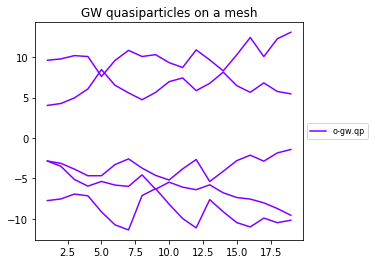

In [22]:
#pack the files in .json files
pack_files_in_folder('gw')

#plot the results using yambm analyser
ya = YamboAnalyser('gw')
#print('plot all qpoints')
ya.plot_gw('qp')

plot along a path
nkpoints: 19
  0.00000000   0.00000000   0.00000000  0
  0.01773050   0.01023671   0.00000000  1
  0.03546099   0.02047341   0.00000000  2
  0.05319149   0.03071012   0.00000000  3
  0.07092198   0.04094682   0.00000000  4
  0.08865248   0.05118353   0.00000000  5
  0.10638299   0.06142025   0.00000000  6
  0.10638299   0.06142025   0.00000000  6
  0.08865249   0.09213037   0.00000000  15
  0.07092200   0.12284049   0.00000000  18
  0.07092200   0.12284049   0.00000000  18
  0.05319149   0.09213036   0.00000000  16
  0.03546099   0.06142024   0.00000000  12
  0.01773050   0.03071012   0.00000000  7
  0.00000000   0.00000000   0.00000000  0


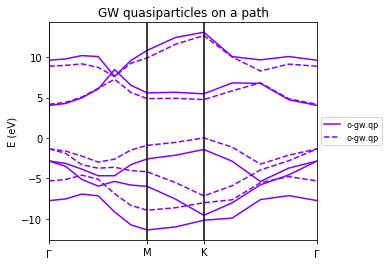

In [25]:
print('plot along a path')
path = [[[0,   0,   0],'$\Gamma$'],
        [[0.5, 0,   0],'M'],
        [[1./3,1./3, 0.0],'K'],
        [[0.0, 0.0, 0.0],'$\Gamma$']]
ya.plot_gw_path('qp',path, cols=(lambda x: x[2]+x[3],2))

running plotting:
reading data-file.xml


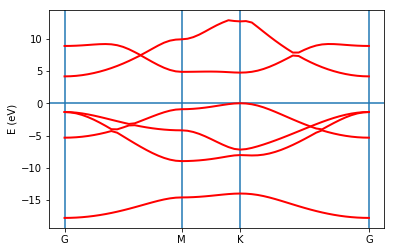

In [26]:
run_plot()